In [1]:
import tensorflow as tf

# Get the Gpu device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
  print('Found GPU at: {}'.format(device_name))
else:
  raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [3]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.4 MB/s eta 0:00:00


In [4]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=f341456a5cff8938794dd49af2d6ac9b75593c93b2377b9c80fe32e2f4ee3e09
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [5]:
import wget
import os

print('Downloading dataset...')

# The URL for the dataset zip file.
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

# Download the file (if we haven't already)
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

In [6]:
# Unzip the dataset (if we haven't already)
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


## Parsing

In [7]:
import pandas as pd

df = pd.read_csv("./cola_public/raw/in_domain_train.tsv",
                 delimiter='\t',
                 header=None,
                 names=['sentence_source', 'label', 'label_notes', 'sentence'])

df.sample(10)

,sentence_source,label,label_notes,sentence
2091,rhl07,1,NaN,"I threw the ball to Mary, but she was looking ..."
1549,r-67,1,NaN,"Tom washed the car, and Dick waxed the car."
1473,r-67,1,NaN,A girl came in who had worn this coat.
2446,l-93,1,NaN,There developed a problem.
2538,l-93,0,*,I put the book from Edna.
2511,l-93,1,NaN,Philippa cried her eyes dry.
1452,r-67,0,*,What kind cf parakeets are they investigating ...
7554,sks13,0,*,I heard John's criticism of myself.
2262,l-93,1,NaN,Jill embraced Sarah.
439,bc01,1,NaN,Mickey teamed up with the women.


In [8]:
df.loc[df.label == 0].sample(5)[['sentence', 'label']]

,sentence,label
7277,For he to win the race would surprise them.,0
4574,Sam may have been being interrogating by the FBI.,0
4939,I met John who grows peaches.,0
5245,Almost an owl hunts mice.,0
7108,Kim likes Sandy and Lee likes to Leslie.,0


In [9]:
sentences = df.sentence.values
labels = df.label.values

# Tokenization and Input Formatting

## BERT Tokenizer

In [10]:
from transformers import BertTokenizer

# Load the BERT Tokenizer
print("Load BERT tokenizer..")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Load BERT tokenizer..


In [11]:
print('Original sentence:', sentences[0])
print('Tokenized sentence:', tokenizer.tokenize(sentences[0]))
print('Token IDs:', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Original sentence: Our friends won't buy this analysis, let alone the next one we propose.
Tokenized sentence: ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs: [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]



1. Add special tokens to the start and end of each sentence.
2. Pad & truncate all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the “attention mask”.


In [12]:
max_len = 0

#for every sentence...
for sent in sentences:

  #Tokenize the text and add [CLS] and [SEP] tokens.
  input_ids = tokenizer.encode(sent, add_special_tokens=True)

  #Update the maximum sentence length
  max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  47


The tokenizer.encode_plus function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special [CLS] and [SEP] tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from [PAD] tokens.


In [13]:
#Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

#for every sentence...
for sent in sentences:
  # `encode_plus` will:
  #   (1) Tokenize the sentence.
  #   (2) Prepend the `[CLS]` token to the start.
  #   (3) Append the `[SEP]` token to the end.
  #   (4) Map tokens to their IDs.
  #   (5) Pad or truncate the sentence to `max_length`
  #   (6) Create attention masks for [PAD] tokens.
  encoded_dict = tokenizer.encode_plus(
                    sent,                         # Sentence to encode
                    add_special_tokens = True,    # Add [CLS] and [SEPT]
                    max_length = 64,              # Pad and truncate all sentences.
                    pad_to_max_length = True,
                    return_attention_mask = True, # Construct attn. masks.
                    return_tensors = 'pt',        # Return pytorch tensors.
  )

  #add encoded sentence to the list
  input_ids.append(encoded_dict["input_ids"])

  #add encoded sentence attention masks to the list
  attention_masks.append(encoded_dict["attention_mask"])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print("Original: ", sentences[0])
print("Token IDs: ", input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs:  tensor([  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,  1010,
         2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


# **Training & Validation Split**



In [14]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

7,695 training samples
  856 validation samples


## Using Pytorch Iterator

In [15]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_dataloader = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset),
    batch_size = batch_size,
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler = SequentialSampler(val_dataset),
    batch_size = batch_size
)

# **Train Our Classification Model**

**BertForSequenceClassification**

In [16]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [17]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

# **Optimizer & Learning Rate Scheduler**

According to the paper, choose the following values;
* **Batch size:** 16, 32
* **Learning rate (Adam):** 5e-5, 3e-5, 2e-5
* **Number of epochs:** 2, 3, 4



In [18]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                  )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [19]:
from transformers import get_linear_schedule_with_warmup

epochs = 4
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps,
)

# **Training Loop**

**Training:**

* Unpack our data inputs and labels
* Load data onto the GPU for acceleration
* Clear out the gradients calculated in the previous pass.
* In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
* Forward pass (feed input data through the network)
* Backward pass (backpropagation)
* Tell the network to update parameters with optimizer.step()
* Track variables for monitoring progress

**Evalution:**

* Unpack our data inputs and labels
* Load data onto the GPU for acceleration
* Forward pass (feed input data through the network)
* Compute loss on our validation data and track variables for monitoring progress


In [20]:
import numpy as np

# to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  print(pred_flat)
  labels_flat = labels.flatten()
  print(labels_flat)
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [21]:
import time
import datetime

def format_time(elapsed):
  elapsed_rounded = int(round(elapsed))
  return str(datetime.timedelta(seconds=elapsed_rounded))

In [22]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        output = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        loss = output[0]
        logits = output[1]
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            output = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels)
            loss = output[0]
            logits = output[1]
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:18.
  Batch    80  of    241.    Elapsed: 0:00:33.
  Batch   120  of    241.    Elapsed: 0:00:46.
  Batch   160  of    241.    Elapsed: 0:01:00.
  Batch   200  of    241.    Elapsed: 0:01:13.
  Batch   240  of    241.    Elapsed: 0:01:27.

  Average training loss: 0.48
  Training epcoh took: 0:01:27

Running Validation...
[1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1]
[1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 0 1 1 1]
[1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0 0]
[1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 0]
[1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1]
[0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 0 0]
[0 1 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1]
[1 1 0 1 1 1 0 1 1 1 1 0 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1 1 0 1 1 0]
[0 1 1 0 1 1 0 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1

In [23]:
import pandas as pd

# Display floats with two decimal places.
# pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats


,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.482956,0.429791,0.821373,0:01:27,0:00:03
2,0.297312,0.446668,0.825231,0:01:21,0:00:03
3,0.185631,0.550778,0.832948,0:01:21,0:00:03
4,0.126670,0.606074,0.832948,0:01:21,0:00:03


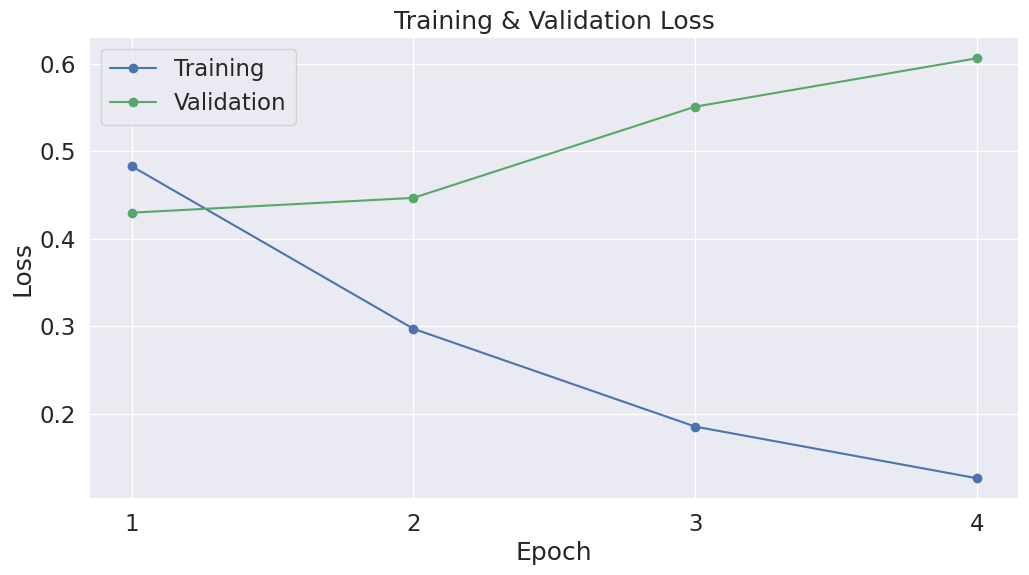

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()


# **Performance on Test Set**

**Data Preparation**

In [32]:
import pandas as pd

df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

print('Number of test sentences: {:,}\n'.format(df.shape[0]))

sentences = df.sentence.values
labels = df.label.values

input_ids = []
attention_masks = []

for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 516



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [33]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

predictions, true_labels = [],[]

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
    output = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels)
  logits = output[1]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 516 test sentences...
    DONE.


In [34]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 354 of 516 (68.60%)


In [35]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  print(predictions[i])
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  print(pred_labels_i)
  print(true_labels[i])
  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...
[[-2.6413324   1.9116535 ]
 [-2.856886    2.1835878 ]
 [-2.7409475   1.8937681 ]
 [-2.7636752   2.090264  ]
 [-2.7490838   1.8707333 ]
 [-2.8475864   2.277307  ]
 [-1.9378841   1.4341687 ]
 [-2.7403133   2.1899087 ]
 [-2.9299629   2.2732823 ]
 [-2.8687656   2.1169448 ]
 [-2.617369    1.612403  ]
 [ 0.71670365 -0.9614162 ]
 [-2.4940965   1.9496628 ]
 [-1.9652541   1.3643918 ]
 [-2.781173    2.0305238 ]
 [-2.4111655   1.8115174 ]
 [-2.4323027   1.9549538 ]
 [ 2.291325   -1.7881215 ]
 [-2.4531415   2.047711  ]
 [-2.6365464   1.710583  ]
 [-2.4531415   2.047711  ]
 [-2.567621    1.6674199 ]
 [-2.044668    1.1647409 ]
 [-2.6913984   2.1112077 ]
 [-2.1522539   1.7510552 ]
 [-2.6594872   2.124156  ]
 [-2.7986763   2.089905  ]
 [-2.5535207   2.078234  ]
 [-2.6098804   2.1359766 ]
 [-2.5229292   1.9469494 ]
 [-2.5958264   2.042003  ]
 [-2.2431214   1.3690946 ]]
[1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 0 0 1

<ipython-input-36-a1af80ea924d>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)


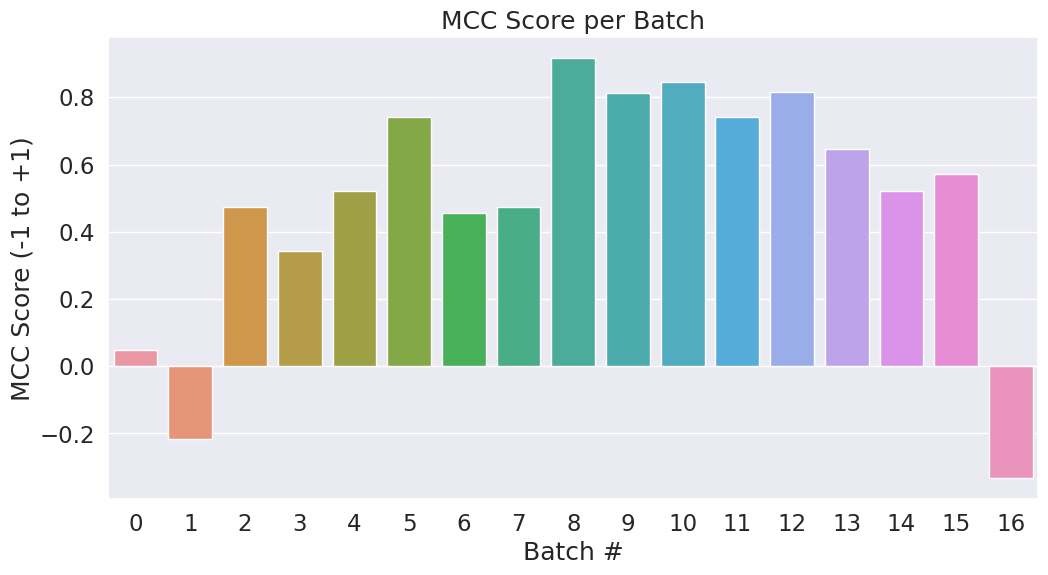

In [36]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [37]:
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.561


## **Saving & Loading Fine-Tuned Model**

In [38]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

In [39]:
!ls -l --block-size=K ./model_save/

total 427984K
-rw-r--r-- 1 root root      1K Sep 18 05:53 config.json
-rw-r--r-- 1 root root 427738K Sep 18 05:53 pytorch_model.bin
-rw-r--r-- 1 root root      1K Sep 18 05:53 special_tokens_map.json
-rw-r--r-- 1 root root      1K Sep 18 05:53 tokenizer_config.json
-rw-r--r-- 1 root root    227K Sep 18 05:53 vocab.txt


In [40]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw-r--r-- 1 root root 418M Sep 18 05:53 ./model_save/pytorch_model.bin


In [42]:
# from google.colab import drive
# drive.mount('/content/drive')

In [43]:
# !cp -r ./model_save/ "./drive/Shared drives/ChrisMcCormick.AI/Blog Posts/BERT Fine-Tuning/"

In [44]:
# # Load a trained model and vocabulary that you have fine-tuned
# model = model_class.from_pretrained(output_dir)
# tokenizer = tokenizer_class.from_pretrained(output_dir)

# # Copy the model to the GPU.
# model.to(device)

# **Weight Decay**

In [45]:
# # This code is taken from:
# # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L102

# # Don't apply weight decay to any parameters whose names include these tokens.
# # (Here, the BERT doesn't have `gamma` or `beta` parameters, only `bias` terms)
# no_decay = ['bias', 'LayerNorm.weight']

# # Separate the `weight` parameters from the `bias` parameters.
# # - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01.
# # - For the `bias` parameters, the 'weight_decay_rate' is 0.0.
# optimizer_grouped_parameters = [
#     # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
#     {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
#      'weight_decay_rate': 0.1},

#     # Filter for parameters which *do* include those.
#     {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
#      'weight_decay_rate': 0.0}
# ]

# # Note - `optimizer_grouped_parameters` only includes the parameter values, not
# # the names.